# Music2Latent tests

<a href="https://colab.research.google.com/github/inspektral/onset-benchmark/blob/main/music2latent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
import os

if 'google.colab' in str(get_ipython()):
    repo_name = 'onset-benchmark'
    repo_path = f'/content/{repo_name}'
    
    # Check if the current working directory is already the repo
    if os.getcwd() != repo_path:
        if not os.path.exists(repo_path):
            !git clone https://github.com/inspektral/onset-benchmark.git
        os.chdir(repo_path)  # Change to the repository directory
        !pip install -r requirements.txt  # Install dependencies

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import synth
from IPython.display import Audio, display
import librosa

import utils
from music2latent import EncoderDecoder

/home/inspektral/miniconda3/envs/mir/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import test_signals

tests = {}

for name, obj in vars(test_signals).items():
    if callable(obj):
        tests[name] = obj

print("Available tests:")
for i, name in enumerate(tests.keys()):
    print(f"{i}: {name}")

Available tests:
0: square_slow
1: square_fast
2: square_vibrato
3: saw_noise
4: sines_noise
5: filter_saw
6: triangle_clip
7: fm_amplitude
8: fm_frequency
9: delay_noise
10: delay_saw
11: reverb_noise
12: reverb_saw


In [18]:
SAMPLE_RATE = 44100
CURRENT_TEST = 0
SMALL = True

Running test: square_slow


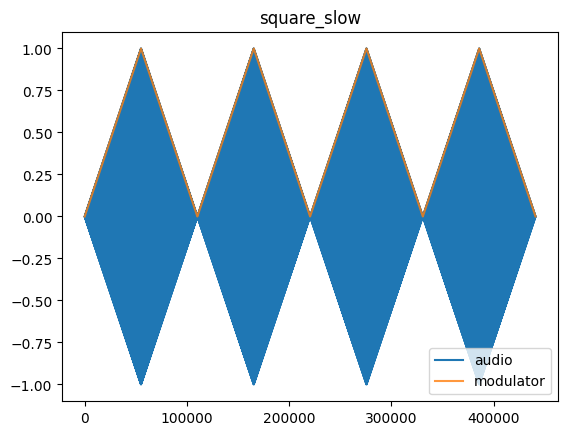

In [19]:
test = tests[list(tests.keys())[CURRENT_TEST]]
print(f"Running test: {test.__name__}")
test_name = test.__name__
audio, modulator = test()

plt.plot(audio, label='audio')
modulator = utils.norm(synth.stretch_array(modulator, len(audio)))
plt.plot(modulator, alpha=0.8, label='modulator')
plt.title(test.__name__)
plt.legend()

plt.show()

display(Audio(audio, rate=SAMPLE_RATE)) 

/home/inspektral/miniconda3/envs/mir/lib/python3.10/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


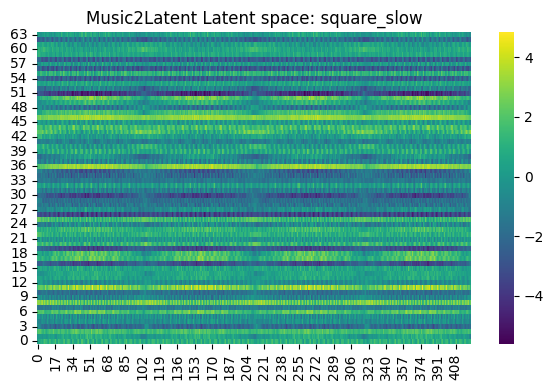

Reconstructed audio:


In [20]:
def encode_audio_to_latent(audio, hop_size=1024):
    encdec = EncoderDecoder()

    all_latent_windows = []

    for i in range(int(4096/hop_size)):
        to_encode = audio[int(i*hop_size):]

        latent = encdec.encode(to_encode)
        latent = latent.cpu().numpy()[0,:,:]
        all_latent_windows.append(latent)

    min_length = min([l.shape[1] for l in all_latent_windows])
    all_latent_windows = [l[:,:min_length] for l in all_latent_windows]

    latent = np.stack(all_latent_windows, axis=2).reshape(all_latent_windows[0].shape[0], -1)

    return latent

latent = encode_audio_to_latent(audio)
utils.plot_heatmap(latent, title="Music2Latent Latent space: "+test_name, small=SMALL)

# reconstructed = encdec.decode(latent)
print(f"Reconstructed audio:")
# display(Audio(reconstructed, rate=SAMPLE_RATE))

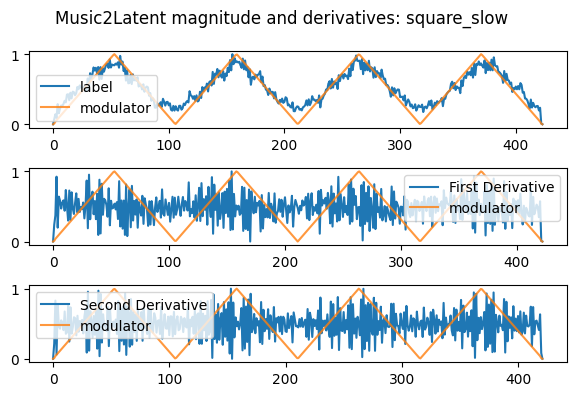

In [21]:

magnitude = np.linalg.norm(latent[:, :], axis=0)
d_magnitude = np.diff(magnitude)
dd_magnitude = np.diff(d_magnitude)

utils.plot_with_derivatives(
    magnitude,
    d_magnitude,
    dd_magnitude,
    modulator,
    title="Music2Latent magnitude and derivatives: "+test_name,
    small=SMALL
)

In [22]:
latent.shape

(64, 424)

distances shape: (3, 423)


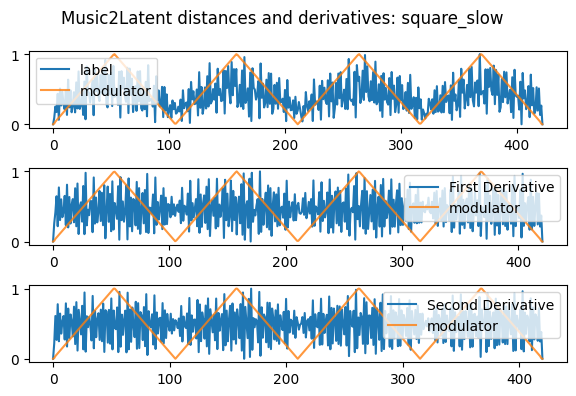

In [23]:
distances = utils.distances(latent[44:47, :])
d_distances = np.diff(distances)
dd_distances = np.diff(d_distances)

utils.plot_with_derivatives(
    distances,
    d_distances,
    dd_distances,
    modulator,
    title="Music2Latent distances and derivatives: "+test_name,
    small=SMALL
)


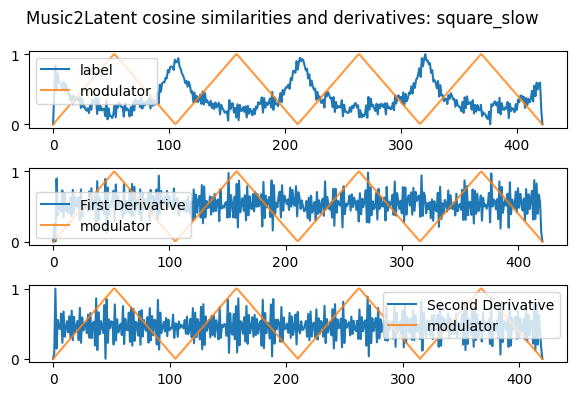

In [24]:
similarities = utils.cosine_similarity(latent)
d_similarities = np.diff(similarities)
dd_similarities = np.diff(d_similarities)

utils.plot_with_derivatives(
    similarities,
    d_similarities,
    dd_similarities,
    modulator,
    title="Music2Latent cosine similarities and derivatives: "+test_name,
    small=SMALL
)